# Part 2: Preprocessing & Modeling

## Imports

In [1]:
# Standard Imports
import nltk
import pandas                        as pd
import numpy                         as np
import seaborn                       as sns
import matplotlib.pyplot             as plt
from IPython.display                 import display_html
from IPython.core.display            import display, HTML

# Proprocessing, Modeling, & Evaluation
from nltk.corpus                     import stopwords
from nltk.stem                       import WordNetLemmatizer
from nltk.tokenize                   import RegexpTokenizer 
from sklearn.ensemble                import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model            import LogisticRegression
from sklearn.model_selection         import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics                 import accuracy_score, recall_score, roc_auc_score
from sklearn.pipeline                import Pipeline
from sklearn.svm                     import SVC
from sklearn.tree                    import DecisionTreeClassifier
from xgboost                         import XGBClassifier


# Custom Modules
import graphs
import metrics

# Notebook settings & styles
sns.set(style = "white", palette = "deep")
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

## Table Of Contents



- [Reading In The Data](#Reading-In-The-Data)
    - [Overview](#Overview)
    - [Visuals](#Visuals)
    
    
- [Lemmatizing](#Lemmatizing)


- [Establishing The Baseline](#Establishing-The-Baseline)


- [Modeling](#Modeling)
    - [Setting The X & y variables](#Setting-The-X-and-y-variables)
    - [Running A Train-Test Split](#Running-A-Train-Test-Split)
    - [Evaluation Metrics](#Evaluation-Metrics)
    - [Logistic Regression](#Logistic-Regression)
    - [Random Forest Classifier](#Random-Forest-Classifier)
    - [Support Vector Classifier](#Support-Vector-Classifier)
    - [XGBoost Classifier](#XGBoost-Classifier)
    
    
- [Evaluation](#Evaluation)
    - [Evaluation Functions](#Evaluation-Functions)
    - [Dataframes](#Dataframes)
    - [Best Model Selection](#Best-Model-Selection)
    - [Plots](#Plots)
        - [Bar Plot](#Bar-Plot)
        - [ROC Curve](#ROC-Curve)

## Reading In The Data

### Overview

In [2]:
model_data = pd.read_csv("../Data/model_data.csv")

In [3]:
# Checking the data's head

model_data.head()

,id,author,source,text,target
0,cbl354,bobs_aspergers,cooking,Does anyone else immediately distrust a recipe...,1
1,cbtuhn,Swigart,cooking,Mortar amp Pestle questions Is marble dust sa...,1
2,cbmrz3,chuy1530,cooking,Weekly menusetting has changed my life Ive alw...,1
3,cb5pvy,Svargas05,cooking,This guy in India has a cooking channel where ...,1
4,cbjt6n,Tg8402,cooking,How do you sear a steak without filling your k...,1


In [4]:
# Checking for null values

model_data.isnull().sum()

id        0
author    0
source    0
text      0
target    0
dtype: int64

In [5]:
# Checking data types

model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3249 entries, 0 to 3248
Data columns (total 5 columns):
id        3249 non-null object
author    3249 non-null object
source    3249 non-null object
text      3249 non-null object
target    3249 non-null int64
dtypes: int64(1), object(4)
memory usage: 127.0+ KB


### Visuals

#### Functions

[Top](#Table-Of-Contents)

#### Text Length

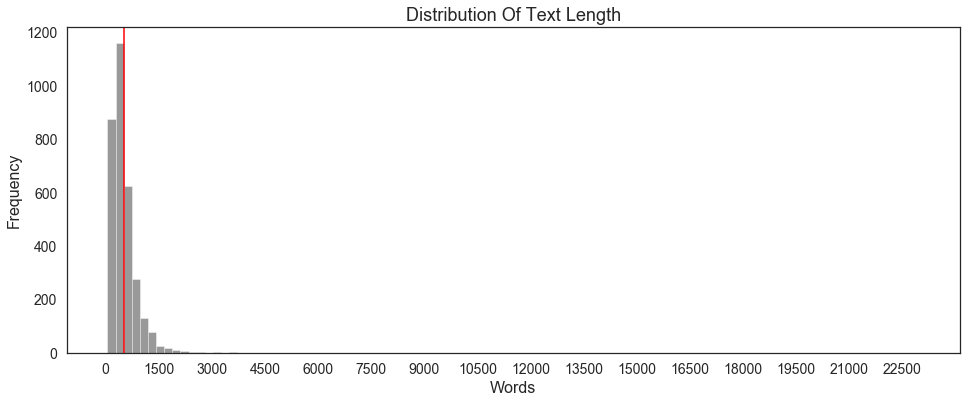

In [6]:
# Generating a list of text lengths

lengths = [len(text) for text in model_data["text"]]

# Plotting the text lengths

plt.figure(figsize = (16,6), facecolor = "white")
sns.distplot(lengths, kde = False, bins = 100, color = "black")
plt.axvline(np.mean(lengths), color = "red")
plt.title("Distribution Of Text Length", size = 18)
plt.xlabel("Words", size = 16)
plt.ylabel("Frequency", size = 16)
plt.xticks(np.arange(0,23500,1500), size = 14)
plt.yticks(size = 14);

# The red line marks the mean length

Most of the posts are less than 3,000 words which was expected, but there are a few that are extremely long (more than 6,000 words.)

####  Most Frequent Authors

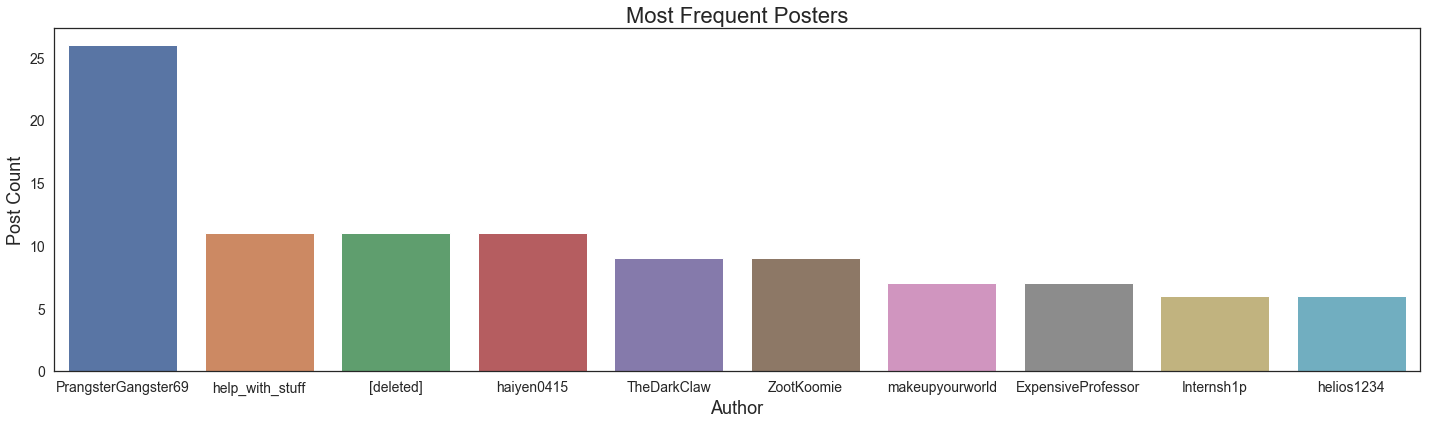

In [7]:
# Creating a dataframe of the most active unique authors

author_count = pd.DataFrame(model_data["author"].value_counts().head(10))

# Plotting the most active authors

graphs.barplot(df     = author_count,
               x      = author_count.index,
               y      = "author",
               title  = "Most Frequent Posters",
               label  = "Author",
               ylabel = "Post Count",
               dim    = (20,6))

We did not really know what to expect when we plotted this graph, because it is generally the case that a few users post most frequently and most barely post at all.  We would have like to look at the number of comments by each user in both subreddits as a measure of activity, but that is beyond the scope of this project.

#### Subreddit Of Origin

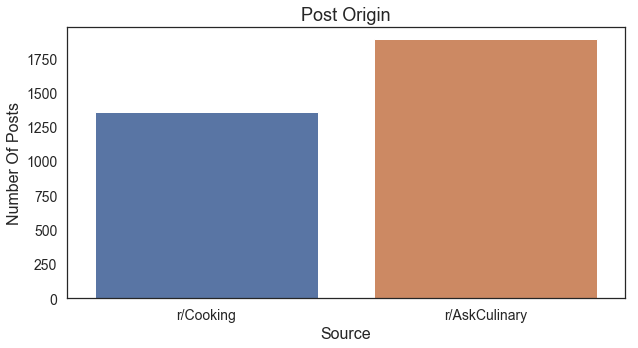

In [8]:
tick_labels = ["r/Cooking", "r/AskCulinary"]

# Setting the figure size
plt.figure(figsize = (10,5))

# Plotting the graph
sns.countplot(model_data["source"])

# Setting graph parameters
plt.title("Post Origin", size = 18)
plt.xlabel("Source", size = 16)
plt.ylabel("Number Of Posts", size = 16)

# Making sure the only ticks are 0 and 1
plt.xticks(np.arange(0,2,1), 
           labels = tick_labels, 
           size   = 14)
plt.yticks(size = 14);

We were a little surprised that there are more r/AskCulinary posts because we initially had roughly equal numbers of pulls from each subreddit.

[Top](#Table-Of-Contents)

#### Visualizing Most Common Words

Before we start modeling, we need to know what the most frequent words are in each subreddit are because it might be harder for our model to predict with those words in the dataframe.

We will subset the dataframe into posts from r/Cooking and r/AskCulinary and use count vectorizer to determine the most frequent words.  The words that occur most frequently will be appended to the set of stop words we will use in our grid searches.

In [9]:
def plot_most_frequent_words(dataframes, titles):
    
    # The count inidcates where in the subplot to go
    count = 0
    fig   = plt.figure(figsize   = (24,20),
                       facecolor = "white")
    
    # Enumerating allows for the list of titles to be referenced
    for d, dataframe in enumerate(dataframes):
        
        # Updating the location
        count += 1
        ax    = fig.add_subplot(2, 2, count)
        
        # Creating the graph
        sns.barplot(x       = 0,
                    y       = dataframe.index,
                    data    = dataframe,
                    palette = "deep")
        
        # Setting the graph parameters
        plt.title(f"Most Common Words From {titles[d]}", size = 20)
        plt.xlabel("Number Of Occurences", size = 18)
        plt.ylabel("Word", size = 18)
        plt.xticks(size = 16)
        plt.yticks(size = 17)

We removed stop words here because they would distort our most common words.

In [10]:
# Instantiating the count vectorizer

vectorizer = CountVectorizer()

# Masking the vectorizer with English stop words

cvec_cooking     = CountVectorizer(stop_words = "english")
cvec_askculinary = CountVectorizer(stop_words = "english")

# Subsetting the dataframe

cooking     = model_data[model_data["target"] == 1]
askculinary = model_data[model_data["target"] == 0]

# Fit-transforming the vectorizer

vec_cooking     = cvec_cooking.fit_transform(cooking["text"])
vec_askculinary = cvec_askculinary.fit_transform(askculinary["text"])

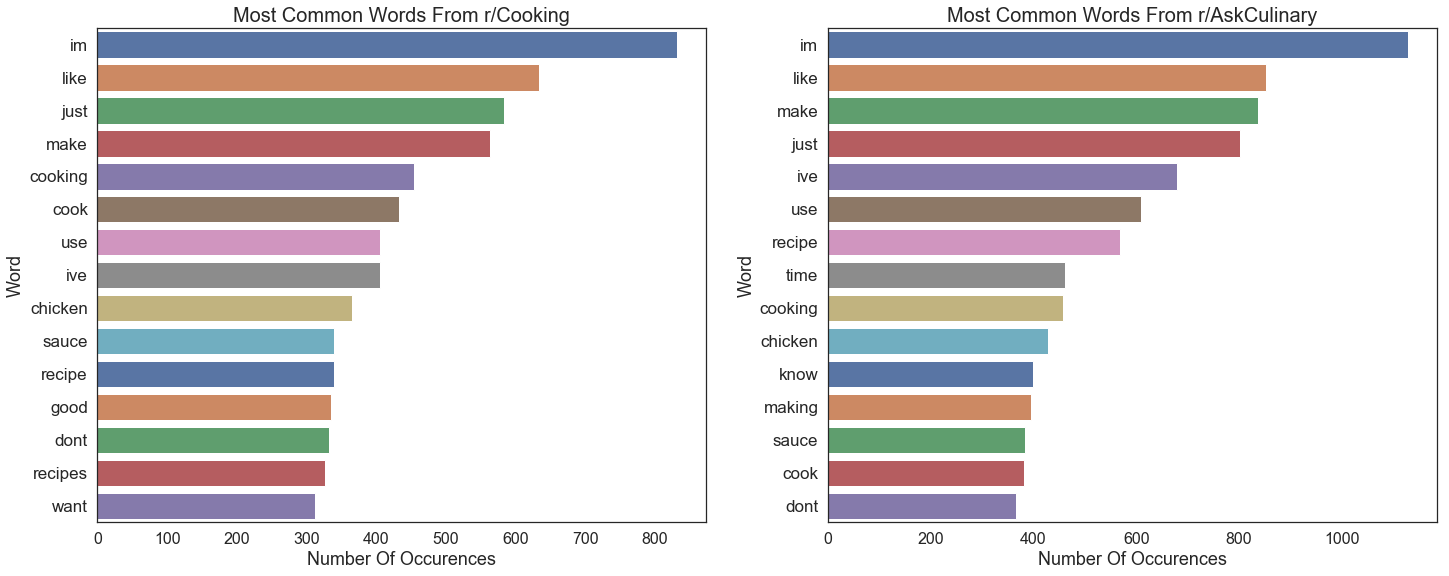

In [11]:
# Saving the vectorized dfs to a new dataframe

cooking_vectorized     = pd.DataFrame(vec_cooking.toarray(), 
                                      columns = cvec_cooking.get_feature_names())
askculinary_vectorized = pd.DataFrame(vec_askculinary.toarray(), 
                                      columns = cvec_askculinary.get_feature_names())

# Getting the 15 most frequent words from each

vectorized_cooking     = pd.DataFrame(cooking_vectorized.sum().sort_values(ascending = False).head(15))
vectorized_askculinary = pd.DataFrame(askculinary_vectorized.sum().sort_values(ascending = False).head(15))

# Plotting the most common words

plot_most_frequent_words(dataframes = [vectorized_cooking, 
                                       vectorized_askculinary],
                         titles     = ["r/Cooking", 
                                       "r/AskCulinary"])

We can see that there are a lot of words that occur in both subreddits.  We decided that we should create a list of customized stop words.  Furthermore, we noticed that we must lemmatize or stem the text columns because of there are multiple forms of words in the most frequent words such as 'make' & 'making' or 'recipe' and 'recipes'.

In [12]:
# Downloading the default stopwords

nltk.download("stopwords");

# Adding our stopwords to the English set

new_stopwords = ["like", "just", "make", "cook",
                 "use", "chicken", "recipe", "sauce"]

stopwords     = stopwords.words('english')

stopwords.extend(new_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[Top](#Table-Of-Contents)

## Lemmatizing

We felt that lemmatizing is a better option than stemming because the lemma form (dictionary entry) of a word is more likely to result in an actual English word than trying to find a word's stem: there are so many irregularities in English that it is not always easy to find the stem.

In [13]:
# Instantiating the lemmatizier and tokenizer
# The tokenizer will only keep text

lemmatizer = WordNetLemmatizer()
tokenizer  = RegexpTokenizer(r'\w+')

# Setting up the lemmatizer

lemmatized_posts = []

for post in model_data["text"]:
    tokens = tokenizer.tokenize(post)
    post   = [lemmatizer.lemmatize(post) for post in tokens]
    lemmatized_posts.append(" ".join(post))
    
# Appending the lemmatized posts to the dataframe

model_data["lemmatized_text"] = lemmatized_posts

# Checking the head of the dataframe

model_data.head()

,id,author,source,text,target,lemmatized_text
0,cbl354,bobs_aspergers,cooking,Does anyone else immediately distrust a recipe...,1,Does anyone else immediately distrust a recipe...
1,cbtuhn,Swigart,cooking,Mortar amp Pestle questions Is marble dust sa...,1,Mortar amp Pestle question Is marble dust safe...
2,cbmrz3,chuy1530,cooking,Weekly menusetting has changed my life Ive alw...,1,Weekly menusetting ha changed my life Ive alwa...
3,cb5pvy,Svargas05,cooking,This guy in India has a cooking channel where ...,1,This guy in India ha a cooking channel where h...
4,cbjt6n,Tg8402,cooking,How do you sear a steak without filling your k...,1,How do you sear a steak without filling your k...


While checking the results from the cell above, we noticed that in `lemmatized_text` there are some URLs which need to be removed.  We used a regular expression to remove all URLs.

In [14]:
model_data["lemmatized_text"] = model_data["lemmatized_text"].str.replace("http\S+", "")

## Establishing The Baseline

A baseline in classification gives us an idea of how exactly the model is performing.  The baseline is simply the percentage of occurrences of our target in the data; in this case it will be what percentage of posts are from r/Cooking.


If our model has an accuracy of greater than 41.89% we know that it is better than simply guessing the class of a post.

In [15]:
round(model_data["target"].value_counts(normalize = True)*100, 2)

0    58.11
1    41.89
Name: target, dtype: float64

The classes are unbalanced, but not severely.  The metrics we use will take the imbalance into account.

## Modeling

Now that our text is in the format we want, we can begin the process of modeling.

There are a few steps we must do before we start running models: we have to define the X and y variables and run a train-test split on the data.

### Setting The X & y variables

In [16]:
X = model_data["lemmatized_text"]
y = model_data["target"]

### Running A Train-Test Split

A train-test split is important because it allows us to reserve a portion of our data for test so that the model does not see all data before predicting.  In this case we want to preserve the distribution of the classes, so we will stratify the data to match the distribution of the classes.

In [17]:
# The random state ensures reproducability
# The stratify argument preserves the distribution of classes

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42,
                                                    stratify     = y)

Each of the three models we will use will be gridsearched so that we can experiment with different combinations of hyperparameters (parameters we have to define).  Additionally, each model will be fit with a count vectorizer and a TFIDF (Term Frequency-Inverse Document Frequency) vectorizer.

[Top](#Table-Of-Contents)

### Evaluation Metrics

One way of evaluation our models will be with a confusion matrix.  A confusion matrix allows us to look at how our model classified our data: it plots the true y values and the predicted y values so that we can have an idea of how the model performs with each class.

We will also use four metics to evaluate our models: accuracy is not enough because we want to know how well the model is doing on each class.

 
| Metric                | Definition                                                       | Scale    |
|:----------------------|:-----------------------------------------------------------------|:---------|
| **Accuracy**          | The overall accuracy of the model                                | 0 to 1   | 
| **Specificity**       | How many negative predictions are correct                        | 0 to 1   | 
| **Sensitivity**       | How many positive predictions are correct (also known as recall) | 0 to 1   | 


For each model we will also calculate a ROC-AUC score.  The ROC (receiver operating characteristic) shows us a binary classification model's ability to distinguish between two classes.  The curve, which will be plotted for our best model, shows us the distribution of the two classes.  The AUC (area under the curve) is how we measure the distribution of the classes: 0.5 is the lowest possible and 1.0 is the highest.

This image from [GreyAtom](https://medium.com/greyatom/lets-learn-about-auc-roc-curve-4a94b4d88152) illustrates the AUC-ROC well:

<img src = "../Images/ROC_AUC 0.8 0.9.png" alt = "high auc_roc scores" height = "350" width = "350">

<img src = "../Images/ROC_AUC 0.5 0.7.png" alt = "low auc_roc scores"  height = "350" width = "350">

[Top](#Table-Of-Contents)

The models will be run with two vectorizers.  In the context of natural language processing, a vectorizer simply extracts features from a set of text.  For this project we decided to use two vectorizers: count vectorization and TFIDF vectorization.

- **Count vectorization**: turns each word into a feature and counts how many times it occurs


- **TFIDF vectorization**: TFIDF (term frequency-inverse document frequency) turns each word into a feature but instead of a number, it returns a percentage of how much of the text it makes up.  Then it scales that percentage by how often it occurs in the entire corpus of text.  It thus has the effect of making uncommon words very significant.

Additionally, the hyperparameters shown in the grid-searches are the optimized hyperparameters.

### Logistic Regression

The logistic regression is very similar to the linear regression, but it uses a logit function to bend the line so that it can predict either 0 or 1.


The gridsearch will be searching hyperparameters for the vectorizers, not the logistic regression.

#### Count Vectorizer

In [18]:
# Setting up the pipeline

cvec_lr_pipe = Pipeline([("cvec", CountVectorizer()), 
                         ("log_reg", LogisticRegression())])

# Setting the CVEC hyperparameters

cvec_pipe_params = {"cvec__max_features": [125], 
                    "cvec__ngram_range" : [(1,2)], 
                    "cvec__stop_words"  : [None]}

# Instantiating the grid search

cvec_lr_gs = GridSearchCV(cvec_lr_pipe, 
                          param_grid = cvec_pipe_params, 
                          cv         = 5)

# Fitting the model to the training data

cvec_lr_gs.fit(X_train, y_train);

# The futurewarning can be ignored

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [19]:
# Generating training predictions

cvec_lr_train_preds = cvec_lr_gs.predict(X_train)

# Generating test predictions

cvec_lr_preds       = cvec_lr_gs.predict(X_test)

In [20]:
# Training metrics

metrics.binary_classification_summary(y_train, cvec_lr_train_preds)

,Score
Accuracy,0.685140
Sensitivity,0.498039
Specificity,0.819915
AUROC,0.658977


In [21]:
# Test metrics

metrics.binary_classification_summary(y_test, cvec_lr_preds)

,Score
Accuracy,0.656827
Sensitivity,0.495601
Specificity,0.773305
AUROC,0.634453


Overall the test scores are poor, although we found it surprising at how consistent they are.  We had expected a degree of overfitting due to the type of model: linear models are simple and tend to high bias.

Our biggest concern is the ROC-AUC score: the scores are close to the lowest possible score and thus the model is not doing a very good job at distinguishing between the posts from r/Cooking and r/AskCulinary.

In [22]:
# Generating a confusion matrix on the test results

metrics.confusion_matrix_dataframe(y_test, 
                                   cvec_lr_preds,
                                   columns = ["Predicted r/AskCulinary", "Predicted r/Cooking"],
                                   index   = ["Actual r/AskCulinary", "Actual r/Cooking"])

,Predicted r/AskCulinary,Predicted r/Cooking
Actual r/AskCulinary,365,107
Actual r/Cooking,172,169


The confusion matrix contains the following:


|                     | Predicted Negative | Predicted Positive |
|:--------------------|:------------------:|:------------------:|
| **Actual Negative** | True Negative      | False Negative     |
| **Actual Positive** | False Positive     | True Positive      |


Based on the matrix, it is easy to see that the model is better at predicting posts from r/AskCulinary than from r/Cooking.  We did not find that surprising at all because there are more posts from r/AskCulinary.

[Top](#Table-Of-Contents)

#### TFIDF Vectorization

In [23]:
# Setting up the pipeline

tvec_lr_pipe = Pipeline([("tvec", TfidfVectorizer()), 
                         ("log_reg", LogisticRegression())])

# Setting TFIDF hyperparameters

tvec_pipe_params = {"tvec__max_features": [650], 
                    "tvec__ngram_range" : [(1,1)], 
                    "tvec__stop_words"  : [None]}
                    
# Instantiating the grid search

tvec_lr_gs = GridSearchCV(tvec_lr_pipe, 
                          param_grid = tvec_pipe_params, 
                          cv         = 5)

# Fitting the model to the training data

tvec_lr_gs.fit(X_train, y_train);

# The warning is a futurewarning and can be ignored

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [24]:
# Generating training predictions

tvec_lr_train_preds = tvec_lr_gs.predict(X_train)

# Generating test predictions

tvec_lr_preds       = tvec_lr_gs.predict(X_test) 

In [25]:
# Training metrics

metrics.binary_classification_summary(y_train, tvec_lr_train_preds)

,Score
Accuracy,0.760263
Sensitivity,0.585294
Specificity,0.886299
AUROC,0.735797


In [26]:
# Test metrics

metrics.binary_classification_summary(y_test, tvec_lr_preds)

,Score
Accuracy,0.687577
Sensitivity,0.519062
Specificity,0.809322
AUROC,0.664192


This model with the TFIDF vectorizer performed a bit better on the test data than the same model with count vectorization.  Nevertheless, this model is more overfit.  The improvement in the ROC-AUC scores is good, but the score is still low.

In [27]:
# Generating a confusion matrix on the test results

metrics.confusion_matrix_dataframe(y_test, 
                                   tvec_lr_preds,
                                   columns = ["Predicted r/AskCulinary", "Predicted r/Cooking"],
                                   index   = ["Actual r/AskCulinary", "Actual r/Cooking"])

,Predicted r/AskCulinary,Predicted r/Cooking
Actual r/AskCulinary,382,90
Actual r/Cooking,164,177


Compared to the confusion matrix for the CVEC predictions, the number of true positives and true negatives have increased while the numbers of false positives and false negatives have decreased as well meaning that the model's predictive power has increased; this reflects what we saw with the model's metrics.  It still predicts the negative class better, which is not surprising.

[Top](#Table-Of-Contents)

### Support Vector Classifier

A support vector machine (in this case a classifier) is at its core a linear model.  However, instead of running like a logistic regression, it seeks to linearly separate the data.  To do that, it uses a kernel to raise the data into _n_-dimensional space.  It then uses a line, plane (3-dimensional line), or hyperplane (greater than 3-dimensions) to delineate the data.

#### Count Vectorizer

In [28]:
# Setting up the pipeline

cvec_svc_pipe = Pipeline([("cvec", CountVectorizer()), 
                         ("svc", SVC())])

# Setting CVEC and pipe hyperparameters

cvec_pipe_params = {"cvec__max_features": [319], 
                    "cvec__ngram_range" : [(1,2)], 
                    "cvec__stop_words"  : [None],
                    "svc__C"            : [1.0],
                    "svc__kernel"       : ["rbf"],
                    "svc__gamma"        : ["auto"]}
                    
# Instantiating the grid search

cvec_svc_gs = GridSearchCV(cvec_svc_pipe, 
                           param_grid = cvec_pipe_params, 
                           cv         = 5)

# Fitting the model to the training data

cvec_svc_gs.fit(X_train, y_train);

In [29]:
# Generating training predictions

cvec_svc_train_preds = cvec_svc_gs.predict(X_train)

# Generating test predictions

cvec_svc_preds       = cvec_svc_gs.predict(X_test) 

In [30]:
# Training metrics

metrics.binary_classification_summary(y_train, cvec_svc_train_preds)

,Score
Accuracy,0.746305
Sensitivity,0.553922
Specificity,0.884887
AUROC,0.719404


In [31]:
# Test metrics

metrics.binary_classification_summary(y_test, cvec_svc_preds)

,Score
Accuracy,0.665437
Sensitivity,0.454545
Specificity,0.817797
AUROC,0.636171


We were surprised that a support vector machine performed worse than the logistic regression: we had expected dramatic improvements over the logistic regression.  While we did note improvements in metric scores, we also noticed that the ROC-AUC score is worse than the logistic regressions.  Because the ROC-AUC score measures the distinction between classes, we were reluctant to say this model is better than the logistic regression.  Furthermore, this model is slightly more overfit than the logistic regression.

In [32]:
# Generating a confusion matrix on the test results

metrics.confusion_matrix_dataframe(y_test, 
                                   cvec_svc_preds,
                                   columns = ["Predicted r/AskCulinary", "Predicted r/Cooking"],
                                   index   = ["Actual r/AskCulinary", "Actual r/Cooking"])

,Predicted r/AskCulinary,Predicted r/Cooking
Actual r/AskCulinary,386,86
Actual r/Cooking,186,155


This model predicts the r/Cooking more than the r/AskCulinary which again we found surprising.  While it did a better job with the true positives, the model predicted more false positives and less of the negative cases overall.

[Top](#Table-Of-Contents)

#### TFIDF Vectorizer

In [33]:
# Setting up the pipeline

tvec_svc_pipe = Pipeline([("tvec", TfidfVectorizer()), 
                         ("svc", SVC())])

# Setting TFIDF and pipe hyperparameters

tvec_pipe_params = {"tvec__max_features": [1], 
                    "tvec__ngram_range" : [(1,1)], 
                    "tvec__stop_words"  : [None],
                    "svc__C"            : [1.0],
                    "svc__kernel"       : ["rbf"],
                    "svc__gamma"        : ["auto"]}
                    
# Instantiating the grid search

tvec_svc_gs = GridSearchCV(tvec_svc_pipe, 
                           param_grid = tvec_pipe_params, 
                           cv         = 5)

# Fitting the model to the training data

tvec_svc_gs.fit(X_train, y_train);

In [34]:
# Generating training predictions

tvec_svc_train_preds = tvec_svc_gs.predict(X_train)

# Generating test predictions

tvec_svc_preds       = tvec_svc_gs.predict(X_test) 

In [35]:
# Training metrics

metrics.binary_classification_summary(y_train, tvec_svc_train_preds)

,Score
Accuracy,0.600985
Sensitivity,0.239216
Specificity,0.861582
AUROC,0.550399


In [36]:
# Test metrics

metrics.binary_classification_summary(y_test, tvec_svc_preds)

,Score
Accuracy,0.602706
Sensitivity,0.240469
Specificity,0.864407
AUROC,0.552438


Considering the performance of the SVC with count vectorization, we were surprised by how much more poorly this model performed: scores in the range of 0.2 to 0.4 are simply unacceptable.  We expected these scores to be slightly higher than the count vectorized scores because in the case of the logistic regression the scores improved with TFIDF vectorization.  Nevertheless, the model is is not overfit at all and in a few cases performed slightly better on the test data.

In [37]:
# Generating a confusion matrix on the test results

metrics.confusion_matrix_dataframe(y_test, 
                                   tvec_svc_preds,
                                   columns = ["Predicted r/AskCulinary", "Predicted r/Cooking"],
                                   index   = ["Actual r/AskCulinary", "Actual r/Cooking"])

,Predicted r/AskCulinary,Predicted r/Cooking
Actual r/AskCulinary,408,64
Actual r/Cooking,259,82


We can see in an increase in the number of true negatives, false positives, but a decrease in true positives and false negatives.  While we welcome a decrease in false negatives, we were surprised by a significant drop in the true positives.

[Top](#Table-Of-Contents)

### Random Forest Classifier

A random forest classifier is a decision tree-based classification method.  However, it has advantages over other tree-based models.  Firstly, it bootstraps the dataframe to have a random subset of the data, but it also takes a random subset of the features.  Having two levels of randomness in the model reduces the likelihood of the model being overfit on training data but it also allows the model to be less prone to variance caused by many features.

#### Count Vectorizer

In [38]:
# Creating the pipeline

cvec_rf_pipe = Pipeline([("cvec", CountVectorizer()), 
                         ("rf", RandomForestClassifier(random_state = 42))])

# Setting CVEC and pipeline hyperparameters

cvec_pipe_params = {"cvec__max_features"   : [1000], 
                    "cvec__ngram_range"    : [(1,1)], 
                    "cvec__stop_words"     : [None],
                    "rf__n_estimators"     : [72],
                    "rf__min_samples_split": [6],
                    "rf__min_samples_leaf" : [2],
                    "rf__max_depth"        : [20]}

# Instantiating the grid search

cvec_rf_gs = GridSearchCV(cvec_rf_pipe, 
                          param_grid = cvec_pipe_params, 
                          cv         = 5,
                          n_jobs     = 6)

# Fitting the model to the training data

cvec_rf_gs.fit(X_train, y_train);

In [39]:
# Generating training predictions

cvec_rf_train_preds = cvec_rf_gs.predict(X_train)

# Generating test predictions

cvec_rf_preds       = cvec_rf_gs.predict(X_test) 

In [40]:
# Training metrics

metrics.binary_classification_summary(y_train, cvec_rf_train_preds)

,Score
Accuracy,0.903941
Sensitivity,0.789216
Specificity,0.986582
AUROC,0.887899


In [41]:
# Test metrics

metrics.binary_classification_summary(y_test, cvec_rf_preds)

,Score
Accuracy,0.664207
Sensitivity,0.340176
Specificity,0.898305
AUROC,0.619241


This random forest model is significantly overfit, which we did not expect because the random forest's two-level randomness is designed to help prevent overfitting; overall this model performed poorly.  Despite the model's poor performance and significant overfitting, this model has by far the best specificity score so far.

In [42]:
# Generating a confusion matrix on the test results

metrics.confusion_matrix_dataframe(y_test, 
                                   cvec_rf_preds,
                                   columns = ["Predicted r/AskCulinary", "Predicted r/Cooking"],
                                   index   = ["Actual r/AskCulinary", "Actual r/Cooking"])

,Predicted r/AskCulinary,Predicted r/Cooking
Actual r/AskCulinary,424,48
Actual r/Cooking,225,116


Here we can see that the true positives and negatives increased while the false negatives and positives decreased.  This is an improvement over the previous model, but it is still not great by any means.

[Top](#Table-Of-Contents)

#### TFIDF Vectorizer

In [43]:
# Creating the pipeline

tvec_rf_pipe = Pipeline([("tvec", TfidfVectorizer()), 
                         ("rf", RandomForestClassifier(random_state = 42))])

# Setting the TVEC and pipeline hyperparameters

tvec_pipe_params = {"tvec__max_features"   : [250], 
                    "tvec__ngram_range"    : [(1,2)], 
                    "tvec__stop_words"     : [None],
                    "rf__n_estimators"     : [30],
                    "rf__min_samples_split": [6],
                    "rf__min_samples_leaf" : [2],
                    "rf__max_depth"        : [12]}

# Instantiating the grid search

tvec_rf_gs = GridSearchCV(tvec_rf_pipe, 
                          param_grid = tvec_pipe_params, 
                          cv         = 5,
                          n_jobs     = 6)

# Fitting the model to the testing data

tvec_rf_gs.fit(X_train, y_train);

In [44]:
# Generating training predictions

tvec_rf_train_preds = tvec_rf_gs.predict(X_train)

# Generating test predictions

tvec_rf_preds       = tvec_rf_gs.predict(X_test) 

In [45]:
# Training metrics

metrics.binary_classification_summary(y_train, tvec_rf_train_preds)

,Score
Accuracy,0.841133
Sensitivity,0.637255
Specificity,0.987994
AUROC,0.812625


In [46]:
# Test metrics

metrics.binary_classification_summary(y_test, tvec_rf_preds)

,Score
Accuracy,0.640836
Sensitivity,0.340176
Specificity,0.858051
AUROC,0.599113


Again, this model is very overfit and performed poorly.  Again, we were surprised by how high the specificity is given the performance of the model otherwise.

In [47]:
# Generating a confusion matrix on the test results

metrics.confusion_matrix_dataframe(y_test, 
                                   tvec_rf_preds,
                                   columns = ["Predicted r/AskCulinary", "Predicted r/Cooking"],
                                   index   = ["Actual r/AskCulinary", "Actual r/Cooking"])

,Predicted r/AskCulinary,Predicted r/Cooking
Actual r/AskCulinary,405,67
Actual r/Cooking,225,116


Interestingly this model had the same number of false positives and true negatives as the previous model, but a slight drop in true negatives and an increase in the false negatives.

[Top](#Table-Of-Contents)

### XGBoost Classifier

XGBoost is a tree-based boosting model that iteratively fits tree models on the errors of the previous model and uses gradient descent to help minimize the loss function.  Furthermore, the XGBoost is much more computationally efficient and can be parallelized unlike other boosting models.

#### Count Vectorizer

In [48]:
# Creating the pipeline
# The model's best parameters are shown

cvec_xgbc_pipe = Pipeline([("cvec", CountVectorizer()), 
                           ("xgbc", XGBClassifier(n_jobs                = 6,
                                                  seed                  = 42,
                                                  early_stopping_rounds = 10))])

# Setting CVEC and pipeline hyperparameters

cvec_pipe_params = {"cvec__max_features"   : [200], 
                    "cvec__ngram_range"    : [(1,3)], 
                    "cvec__stop_words"     : [None],
                    "xgbc__max_depth"      : [3],
                    "xgbc__learning_rate"  : [0.04],
                    "xgbc__n_estimators"   : [175],
                    "xgbc__gamma"          : [3.0]}

# Instantiating the grid search

cvec_xgbc_gs = GridSearchCV(cvec_xgbc_pipe, 
                            param_grid = cvec_pipe_params, 
                            cv         = 5,
                            n_jobs     = 6)

# Fitting the model to the testing data

cvec_xgbc_gs.fit(X_train, y_train);

In [49]:
# Generating training predictions

cvec_xgbc_train_preds = cvec_xgbc_gs.predict(X_train)

# Generating test predictions

cvec_xgbc_preds       = cvec_xgbc_gs.predict(X_test) 

In [50]:
# Training metrics

metrics.binary_classification_summary(y_train, cvec_xgbc_train_preds)

,Score
Accuracy,0.757389
Sensitivity,0.530392
Specificity,0.920904
AUROC,0.725648


In [51]:
# Test metrics

metrics.binary_classification_summary(y_test, cvec_xgbc_preds)

,Score
Accuracy,0.649446
Sensitivity,0.404692
Specificity,0.826271
AUROC,0.615482


We had expected the XGBoost classifier to be the best model because it is a boosting model: it fits models on the errors from each model it fits.  This model is bad not only because of how low the scores are, but because of how overfit the model is.

In [52]:
# Generating a confusion matrix on the test results

metrics.confusion_matrix_dataframe(y_test, 
                                   cvec_xgbc_preds,
                                   columns = ["Predicted r/AskCulinary", "Predicted r/Cooking"],
                                   index   = ["Actual r/AskCulinary", "Actual r/Cooking"])

,Predicted r/AskCulinary,Predicted r/Cooking
Actual r/AskCulinary,390,82
Actual r/Cooking,203,138


The matrices have been variable over previous models and this one is no different: true positives, true true negatives, and false negatives decreased while the false negatives increased.

[Top](#Table-Of-Contents)

#### TFIDF Vectorizer

In [53]:
# Creating the pipeline
# The model's best parameters are shown

tvec_xgbc_pipe = Pipeline([("tvec", TfidfVectorizer()), 
                           ("xgbc", XGBClassifier(n_jobs                = 6,
                                                  seed                  = 42,
                                                  early_stopping_rounds = 10))])

# Setting the TFIDF and pipeline hyperparameters

tvec_pipe_params = {"tvec__max_features"   : [525], 
                    "tvec__ngram_range"    : [(1,3)], 
                    "tvec__stop_words"     : [stopwords],
                    "xgbc__max_depth"      : [3],
                    "xgbc__learning_rate"  : [0.25],
                    "xgbc__n_estimators"   : [139],
                    "xgbc__gamma"          : [1.0]}

# Instantiating the grid search

tvec_xgbc_gs = GridSearchCV(tvec_xgbc_pipe, 
                            param_grid = tvec_pipe_params, 
                            cv         = 5,
                            n_jobs     = 6)

# Fitting the model to the testing data

tvec_xgbc_gs.fit(X_train, y_train);

In [54]:
# Generating training predictions

tvec_xgbc_train_preds = tvec_xgbc_gs.predict(X_train)

# Generating test predictions

tvec_xgbc_preds       = tvec_xgbc_gs.predict(X_test) 

In [55]:
# Training metrics

metrics.binary_classification_summary(y_train, tvec_xgbc_train_preds)

,Score
Accuracy,0.893268
Sensitivity,0.800980
Specificity,0.959746
AUROC,0.880363


In [56]:
# Test metrics

metrics.binary_classification_summary(y_test, tvec_xgbc_preds)

,Score
Accuracy,0.653137
Sensitivity,0.501466
Specificity,0.762712
AUROC,0.632089


Again we were surprised by how poorly the XGBoost model did for the same reasons: it is extremely overfit and its metric scores are poor.

In [57]:
# Generating a confusion matrix on the test results

metrics.confusion_matrix_dataframe(y_test, 
                                   tvec_xgbc_preds,
                                   columns = ["Predicted r/AskCulinary", "Predicted r/Cooking"],
                                   index   = ["Actual r/AskCulinary", "Actual r/Cooking"])

,Predicted r/AskCulinary,Predicted r/Cooking
Actual r/AskCulinary,360,112
Actual r/Cooking,170,171


This matrix is dramatically worse than the previous: the true positives increased, the true negatives and false positives decreased, and the false negatives increased.

[Top](#Table-Of-Contents)

## Evaluation

### Evaluation Functions

In [58]:
# This function allows for dataframes to be displayed side-by-side

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'), raw = True)

The code is from user `ntg` on StackOverflow.  [Here](https://stackoverflow.com/a/44923103) is the source.

### Dataframes

In [59]:
# Count vectorizer metrics

cvec_accuracy          = [accuracy_score(y_test, cvec_lr_preds), 
                          accuracy_score(y_test, cvec_svc_preds),
                          accuracy_score(y_test, cvec_rf_preds), 
                          accuracy_score(y_test, cvec_xgbc_preds)]

cvec_specificity       = [metrics.specificity(y_test, cvec_lr_preds), 
                          metrics.specificity(y_test, cvec_svc_preds),
                          metrics.specificity(y_test, cvec_rf_preds), 
                          metrics.specificity(y_test, cvec_xgbc_preds)]

cvec_sensitivity       = [recall_score(y_test, cvec_lr_preds), 
                          recall_score(y_test, cvec_svc_preds),
                          recall_score(y_test, cvec_rf_preds), 
                          recall_score(y_test, cvec_xgbc_preds)]

cvec_rocauc_score      = [roc_auc_score(y_test, cvec_lr_preds),
                          roc_auc_score(y_test, cvec_svc_preds),
                          roc_auc_score(y_test, cvec_rf_preds),
                          roc_auc_score(y_test, cvec_xgbc_preds)]

In [60]:
# TFIDF vectorizer metrics

tvec_accuracy          = [accuracy_score(y_test, tvec_lr_preds), 
                          accuracy_score(y_test, tvec_svc_preds),
                          accuracy_score(y_test, tvec_rf_preds), 
                          accuracy_score(y_test, tvec_xgbc_preds)]

tvec_specificity       = [metrics.specificity(y_test, tvec_lr_preds), 
                          metrics.specificity(y_test, tvec_svc_preds),
                          metrics.specificity(y_test, tvec_rf_preds), 
                          metrics.specificity(y_test, tvec_xgbc_preds)]

tvec_sensitivity       = [recall_score(y_test, tvec_lr_preds), 
                          recall_score(y_test, tvec_svc_preds),
                          recall_score(y_test, tvec_rf_preds), 
                          recall_score(y_test, tvec_xgbc_preds)]

tvec_rocauc_score      = [roc_auc_score(y_test, tvec_lr_preds),
                          roc_auc_score(y_test, tvec_svc_preds),
                          roc_auc_score(y_test, tvec_rf_preds),
                          roc_auc_score(y_test, tvec_xgbc_preds)]

In [61]:
# Converting the lists into dataframes

# A dataframe for the CVEC scores

cvec_scores = pd.DataFrame(data    = [cvec_accuracy, cvec_specificity, 
                                      cvec_sensitivity, cvec_rocauc_score],
                           columns = ["Log. Reg.", "SVC", "Random Forest", "XGBoost"],
                           index   = ["Accuracy", "Specificity", "Sensitivity", "ROC-AUC Score"])

# A dataframe for the TVEC scores

tvec_scores = pd.DataFrame(data    = [tvec_accuracy, tvec_specificity, 
                                      tvec_sensitivity, tvec_rocauc_score],
                           columns = ["Log. Reg.", "SVC", "Random Forest", "XGBoost"],
                           index   = ["Accuracy", "Specificity", "Sensitivity", "ROC-AUC Score"])

In [62]:
# Displaying the two dataframes side by side

display_side_by_side(cvec_scores,
                     tvec_scores)

# The first table is the CVEC scores
# The second table is the TVEC scores

,Log. Reg.,SVC,Random Forest,XGBoost
Accuracy,0.656827,0.665437,0.664207,0.649446
Specificity,0.773305,0.817797,0.898305,0.826271
Sensitivity,0.495601,0.454545,0.340176,0.404692
ROC-AUC Score,0.634453,0.636171,0.619241,0.615482
,Log. Reg.,SVC,Random Forest,XGBoost
Accuracy,0.687577,0.602706,0.640836,0.653137
Specificity,0.809322,0.864407,0.858051,0.762712
Sensitivity,0.519062,0.240469,0.340176,0.501466
ROC-AUC Score,0.664192,0.552438,0.599113,0.632089


[Top](#Table-Of-Contents)

### Best Model Selection

We knew that our best model would be with the TFIDF vectorizer because the scores are generally better than with the count vectorizer.  However, picking the individual model was the tricky part.  We knew that the logistic regression was generally better but did have one of the lowest sensitivity scores.  However, in the end we decided that the logistic regression is the best model.

### Plots

#### Bar Plots

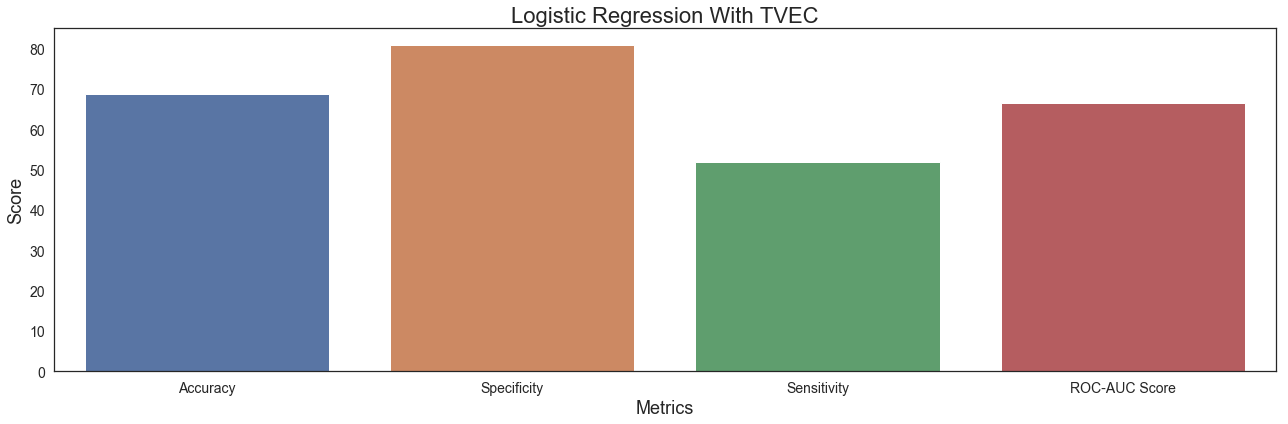

In [63]:
graphs.barplot(df     = tvec_scores*100,
               x      = tvec_scores.index,
               y      = "Log. Reg.",
               title  = "Logistic Regression With TVEC",
               label  = "Metrics",
               ylabel = "Score",
               dim    = (18,6))

Our baseline accuracy is 41.89%: if the accuracy was less than the baseline accuracy it would indicate the model performs worse than randomly guessing 41.89% of the data is from r/Cooking.  However, both the are greater than that percentage so it out-performed the baseline.  That being said, the scores are not good and we cannot say that this model is especially accurate even though the it performed better than the other seven we ran.  Despite that, it is a good sign that the accuracy and balanced accuracy are close to each other.


As mentioned above, `specificity` is the how many negative predictions were correct and `Sensitivity` is how many positive predictions are correct.  As we said with the confusion matrices, the models were better at predicting the negative class which is easily seen here.

The `ROC-AUC` score is okay, but it leaves a lot to be desired.

#### ROC Curve

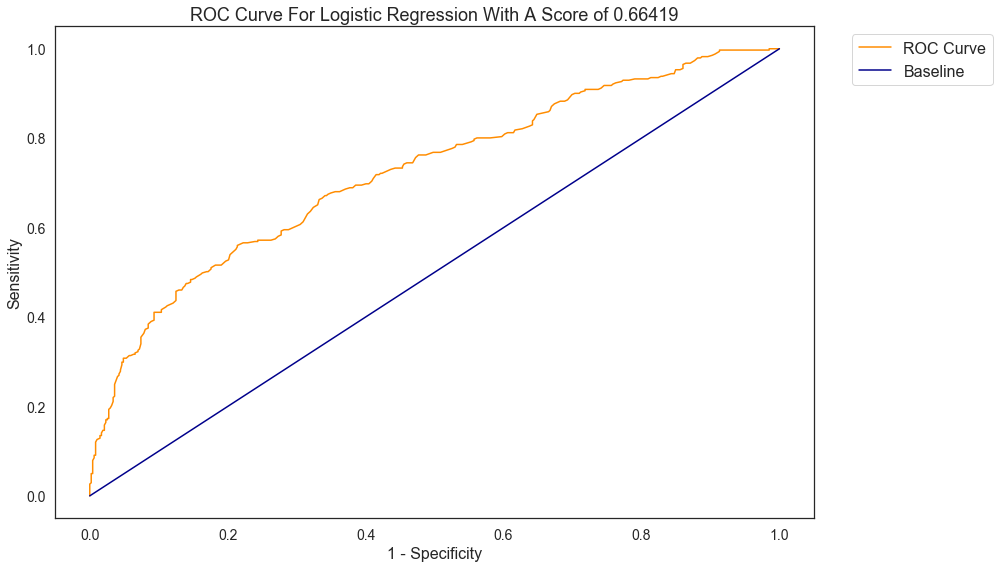

In [64]:
graphs.roc_curve(model_prob  = tvec_lr_gs,
                 X_test      = X_test,
                 y_test      = y_test,
                 y_predicted = tvec_lr_preds,
                 title       = "ROC Curve For Logistic Regression",
                 dim         = (14,8))

The ROC curve is a representation of the relationship between the true positives and the false positives.

The low score indicates that the model is not very good at predicting the two classes, which we also saw from the confusion matrices.  Furthermore, the curve is close to the baseline; the baseline represents guessing which subreddit a post came from. Thus we hoped to have our curve be as far from the baseline as possible, ideally at a 90º angle.

Because our best ROC-AUC score is 0.66419 it means that there is _significant_ overlap in the distributions of our classes.

[Top](#Table-Of-Contents)